In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import json
import os
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cairosvg
from PIL import Image

2025-01-18 13:36:00.902573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737207360.919541  110841 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737207360.924622  110841 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 13:36:00.942391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Динамічне виділення пам'яті
    except RuntimeError as e:
        print(e)

In [3]:
with open("../configs/config.json", "r") as file:
    config = json.load(file)

# Виведення конфігурації
print(config)

{'data': {'raw_path': '../data/raw/svg', 'png_path': '../data/precessed/png_images', 'precessed_train_path': '../data/tfrec/train/', 'precessed_valid_path': '../data/tfrec/val/', 'class_names': ['airplane', 'alarm clock', 'angel', 'ant', 'apple', 'arm', 'armchair', 'ashtray', 'axe', 'backpack', 'banana', 'barn', 'baseball bat', 'basket', 'bathtub', 'bear (animal)', 'bed', 'bee', 'beer-mug', 'bell', 'bench', 'bicycle', 'binoculars', 'blimp', 'book', 'bookshelf', 'boomerang', 'bottle opener', 'bowl', 'brain', 'bread', 'bridge', 'bulldozer', 'bus', 'bush', 'butterfly', 'cabinet', 'cactus', 'cake', 'calculator', 'camel', 'camera', 'candle', 'cannon', 'canoe', 'car (sedan)', 'carrot', 'castle', 'cat', 'cell phone', 'chair', 'chandelier', 'church', 'cigarette', 'cloud', 'comb', 'computer monitor', 'computer-mouse', 'couch', 'cow', 'crab', 'crane (machine)', 'crocodile', 'crown', 'cup', 'diamond', 'dog', 'dolphin', 'donut', 'door', 'door handle', 'dragon', 'duck', 'ear', 'elephant', 'envelope

In [13]:
# Constants
IMAGE_SIZE = (config['model']['input_size'], config['model']['input_size'])
BATCH_SIZE = config['model']['batch_size']
NUM_CLASSES = config['model']['output_size']
PNG_DIR = config['data']['png_path']
TFREC_TRAIN_DIR = config['data']['precessed_train_path']
TFREC_VALID_DIR = config['data']['precessed_valid_path']
MODEL_FINAL_DIR = config['training']['final_model_dir']
class_names = sorted(os.listdir(PNG_DIR))

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Функція для парсингу TFRecord
def parse_tfrecord_onehot(example_proto, num_classes):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([num_classes], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)  # Декодуємо JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Конвертуємо в float32
    label = example['label']
    return image, label

# Завантажуємо TFRecord файли
def load_tfrecord_onehot_dataset(tfrecord_files, num_classes, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(lambda x: parse_tfrecord_onehot(x, num_classes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Випадкове віддзеркалення
    return image

# Функція для застосування аугментації під час завантаження даних
def augment_image_during_training(image, label):
    image = augment_image(image)
    return image, label


# Завантажуємо тренувальний датасет
train_tfrecord_files = [os.path.join(TFREC_TRAIN_DIR, f) for f in os.listdir(TFREC_TRAIN_DIR) if f.endswith('.tfrecord')]
train_dataset = load_tfrecord_onehot_dataset(train_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Застосовуємо аугментацію до тренувального датасету
# train_dataset = train_dataset.map(
#     augment_image_during_training,
#     num_parallel_calls=tf.data.experimental.AUTOTUNE
# )

# Додаємо батчування та prefetch для оптимізації
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Розраховуємо загальну кількість тренувальних зразків
total_train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_tfrecord_files))
steps_per_epoch = total_train_samples // BATCH_SIZE

# Завантажуємо валідаційний датасет
val_tfrecord_files = [os.path.join(TFREC_VALID_DIR, f) for f in os.listdir(TFREC_VALID_DIR) if f.endswith('.tfrecord')]
val_dataset = load_tfrecord_onehot_dataset(val_tfrecord_files, NUM_CLASSES, batch_size=BATCH_SIZE)

# Додаємо батчування та prefetch для валідаційного датасету
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Розраховуємо загальну кількість валідаційних зразків
total_val_samples = sum(1 for _ in tf.data.TFRecordDataset(val_tfrecord_files))
validation_steps = total_val_samples // BATCH_SIZE




I0000 00:00:1737207363.052210  110841 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6
2025-01-18 13:36:03.158661: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-01-18 13:36:05.110418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-18 13:36:05.593832: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


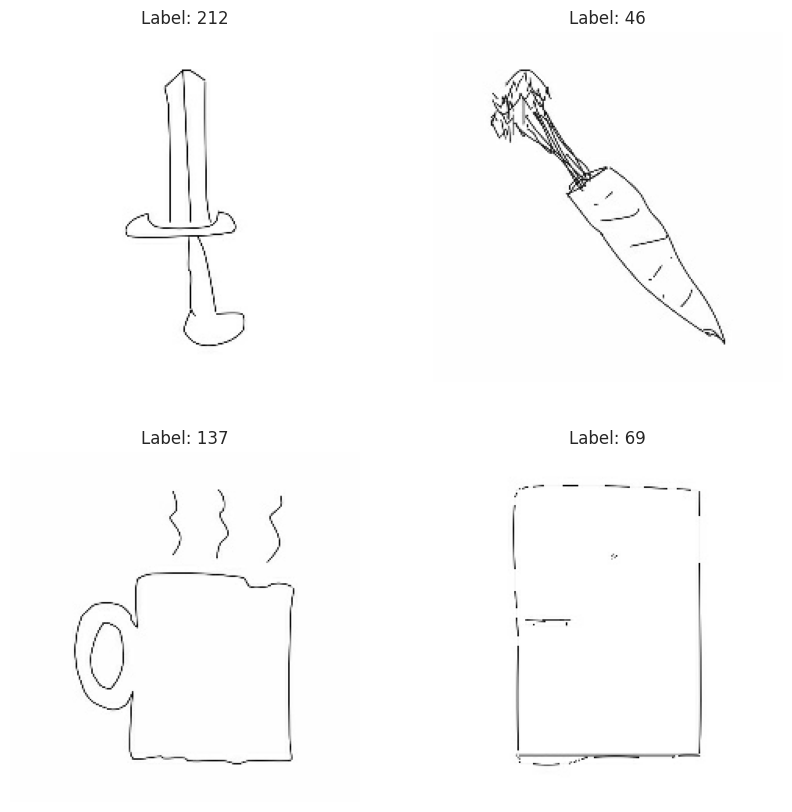

In [6]:
def visualize_images(dataset, num_images=4, is_onehot=False):
    # Беремо один батч з даними
    for images, labels in dataset.take(1):
        images = images.numpy()  # Конвертуємо тензори в NumPy
        labels = labels.numpy()

        # Перевіряємо, чи є дані в батчі
        batch_size = images.shape[0]
        if batch_size == 0:
            raise ValueError("Батч порожній, перевірте ваш датасет.")
        
        # Візуалізуємо тільки до num_images зображень
        num_images = min(num_images, batch_size)

        # Створюємо сітку для візуалізації
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(2, 2, i + 1)
            
            # Отримуємо одне зображення
            image = images[i]

            # Відображення залежно від діапазону значень
            if image.max() > 1.0:
                plt.imshow(image.astype('uint8'))
            else:
                plt.imshow(image)
            
            # Отримуємо мітку
            if is_onehot:
                label = np.argmax(labels[i])
            else:
                label = labels[i]
            
            plt.title(f"Label: {label}")
            plt.axis('off')
        plt.show()

# Виклик функції з урахуванням батчів
visualize_images(train_dataset, is_onehot=True)


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Функція для створення моделі
def create_model():
    # Завантаження базової моделі
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    
    # Заморожуємо базову модель
    base_model.trainable = False

    # Додаємо власні шари
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, x)
    return model

# Створюємо модель
model = create_model()
model.summary()

# Компіляція моделі
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipykernel_110841/3984194834.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │       128,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,042,106 (11.60 MB)

 Trainable params: 784,122 (2.99 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# Колбеки
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
]

# Етап 1: Навчання верхніх шарів
print("Етап 1: Навчання верхніх шарів...")
start_time = time.time()

history_stage_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps 
)

print(f"Час навчання етапу 1: {time.time() - start_time:.2f} секунд")

Етап 1: Навчання верхніх шарів...
Epoch 1/10


I0000 00:00:1737207371.387469  110939 service.cc:148] XLA service 0x7f9314040c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737207371.387581  110939 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-01-18 13:36:11.482562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737207372.073177  110939 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-18 13:36:13.127293: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680_0', 104 bytes spill stores, 136 bytes spill loads

2025-01-18 13:36:13.482680: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680', 2

  5/499 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.0012 - loss: 5.9543     

I0000 00:00:1737207381.311726  110939 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0700 - loss: 4.8999

2025-01-18 13:36:33.841910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1188', 16 bytes spill stores, 16 bytes spill loads



499/499 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.0701 - loss: 4.8986 - val_accuracy: 0.3607 - val_loss: 2.8466 - learning_rate: 0.0010
Epoch 2/10


2025-01-18 13:36:39.797966: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680', 16 bytes spill stores, 16 bytes spill loads

2025-01-18 13:36:40.094543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680_0', 344 bytes spill stores, 520 bytes spill loads

2025-01-18 13:36:40.457881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680', 208 bytes spill stores, 208 bytes spill loads

2025-01-18 13:36:40.698975: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4652', 32 bytes spill stores, 32 bytes spill loads

2025-01-18 13:36:40.994952: I external/local_xla/xla/s

  1/499 ━━━━━━━━━━━━━━━━━━━━ 1:12:55 9s/step - accuracy: 0.1935 - loss: 3.2255

2025-01-18 13:36:47.510956: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/qizixxx/mlbook/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1935 - loss: 3.2255 - val_accuracy: 0.3602 - val_loss: 2.8411 - learning_rate: 0.0010
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.2819 - loss: 3.0477 - val_accuracy: 0.4475 - val_loss: 2.3037 - learning_rate: 0.0010
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3548 - loss: 2.7632 - val_accuracy: 0.4507 - val_loss: 2.3012 - learning_rate: 0.0010
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.3767 - loss: 2.5343 - val_accuracy: 0.4865 - val_loss: 2.0795 - learning_rate: 0.0010
Epoch 6/10
  1/499 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5484 - loss: 2.0549

2025-01-18 13:37:16.648891: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5484 - loss: 2.0549 - val_accuracy: 0.4877 - val_loss: 2.0815 - learning_rate: 0.0010
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.4334 - loss: 2.2594 - val_accuracy: 0.5125 - val_loss: 1.9372 - learning_rate: 0.0010
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4194 - loss: 2.1999 - val_accuracy: 0.5138 - val_loss: 1.9360 - learning_rate: 0.0010
Epoch 9/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.4656 - loss: 2.0797 - val_accuracy: 0.5245 - val_loss: 1.8680 - learning_rate: 0.0010
Epoch 10/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3871 - loss: 1.9667 - val_accuracy: 0.5230 - val_loss: 1.8667 - learning_rate: 0.0010
Час навчання етапу 1: 100.34 секунд


In [10]:

# Розморожуємо верхні шари базової моделі
print("Розморожуємо верхні шари...")
model.trainable = True
for layer in model.layers[:-30]:  # Заморожуємо всі шари, окрім останніх 30
    layer.trainable = False

# Перекомпіляція моделі з низьким learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Розморожуємо верхні шари...


In [11]:

# Етап 2: Fine-tuning базової моделі
print("Етап 2: Fine-tuning базової моделі...")
start_time = time.time()

history_stage_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps 
)

print(f"Час навчання етапу 2: {time.time() - start_time:.2f} секунд")


Етап 2: Fine-tuning базової моделі...
Epoch 1/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5109 - loss: 1.8286 - val_accuracy: 0.5575 - val_loss: 1.7372 - learning_rate: 1.0000e-04
Epoch 2/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6129 - loss: 1.7336 - val_accuracy: 0.5577 - val_loss: 1.7372 - learning_rate: 1.0000e-04
Epoch 3/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5590 - loss: 1.6943 - val_accuracy: 0.5617 - val_loss: 1.7088 - learning_rate: 1.0000e-04
Epoch 4/20
  1/499 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5484 - loss: 1.6297

2025-01-18 13:39:11.174324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5484 - loss: 1.6297 - val_accuracy: 0.5615 - val_loss: 1.7087 - learning_rate: 1.0000e-04
Epoch 5/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5652 - loss: 1.6583 - val_accuracy: 0.5648 - val_loss: 1.6984 - learning_rate: 1.0000e-04
Epoch 6/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5806 - loss: 1.5521 - val_accuracy: 0.5648 - val_loss: 1.6984 - learning_rate: 1.0000e-04
Epoch 7/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5684 - loss: 1.6078 - val_accuracy: 0.5700 - val_loss: 1.6855 - learning_rate: 1.0000e-04
Epoch 8/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6129 - loss: 1.5713 - val_accuracy: 0.5700 - val_loss: 1.6854 - learning_rate: 1.0000e-04
Epoch 9/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5745 - loss: 1.5946 - val_accuracy: 0.5750 - val_loss: 1.6771 - learning_rate: 1.0000e-04
Epoch 10/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.48

2025-01-18 13:40:54.559637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10884387956982460125
2025-01-18 13:40:54.559779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7913940122525167068


499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4839 - loss: 1.6067 - val_accuracy: 0.5807 - val_loss: 1.6493 - learning_rate: 1.0000e-04
Epoch 19/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6063 - loss: 1.4580 - val_accuracy: 0.5813 - val_loss: 1.6411 - learning_rate: 1.0000e-04
Epoch 20/20
  1/499 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6774 - loss: 1.3034

2025-01-18 13:41:08.538997: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6774 - loss: 1.3034 - val_accuracy: 0.5817 - val_loss: 1.6412 - learning_rate: 1.0000e-04
Час навчання етапу 2: 159.06 секунд


In [14]:
# Збереження моделі
model.save(MODEL_FINAL_DIR + 'mobilenetv2_day_four.h5')


Запустіть TensorBoard для моніторингу навчання: tensorboard --logdir=./logs


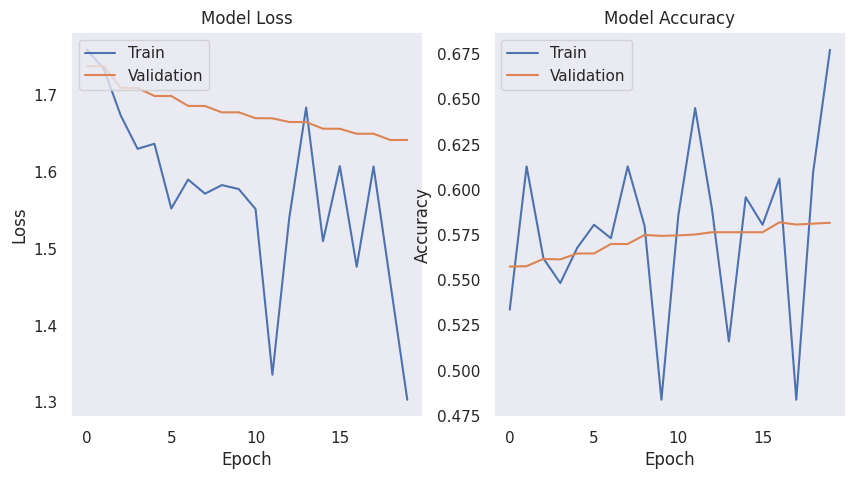

In [16]:
#plotting loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_stage_2.history['loss'])
plt.plot(history_stage_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_stage_2.history['accuracy'])
plt.plot(history_stage_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Розморожуємо всі шари базової моделі
model.trainable = True

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.9
)

# Перекомпіляція з дуже низьким learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Навчання з новими параметрами
history_stage_3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,  # Кількість кроків на епоху
    validation_steps=validation_steps 
)


In [ ]:
#plotting loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_stage_3.history['loss'])
plt.plot(history_stage_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_stage_3.history['accuracy'])
plt.plot(history_stage_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Збереження моделі
model.save(MODEL_FINAL_DIR + 'mobilenetv2_day_four_v2.h5')
